In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from rasterio.enums import Resampling
from PIL import ImageColor
from skimage.exposure import rescale_intensity

In [2]:
# Location of data
lc_dir = 'data/lc.json'
lc_image_dir = 'https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/LC_Image_v1.tif'
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [3]:
# Load Land Cover Parameter
lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

palette  values                      label  values_normalize
0   #006400    2001     Primary dryland forest                 1
1   #228B22    2002   Secondary dryland forest                 2
2   #4B0082    2004    Primary mangrove forest                 3
3   #808000    2005       Primary swamp forest                 4
4   #32CD32    2006          Plantation forest                 5
5   #90EE90    2007                  Dry shrub                 6
6   #FF4500    2010                Estate crop                 7
7   #F08080    2012                 Settlement                 8
8   #D2B48C    2014                Bare ground                 9
9   #ADFF2F    3000        Savanna and grasses                10
10  #87CEFA    5001                 Open water                11
11  #6A5ACD   20041  Secondary mangrove forest                12
12  #6B8E23   20051     Secondary swamp forest                13
13  #66CDAA   20071                  Wet shrub                14
14  #FFD700   20091       Pure dry agriculture                15
15  #FFA500   20092      Mixed dry agriculture                16
16  #008080   20093                Paddy field                17
17  #E6E6FA   20094      Fish pond/aquaculture                18
18  #B22222   20121            Port or harbour                19
19  #C71585   20122       Transmigration areas                20
20  #A0522D   20141                     Mining                21
21  #7FFFD4   50011                      Swamp                22

In [4]:
# Load land cover image
lc_source = rio.open(lc_image_dir)
lc_image = lc_source.read()[0]

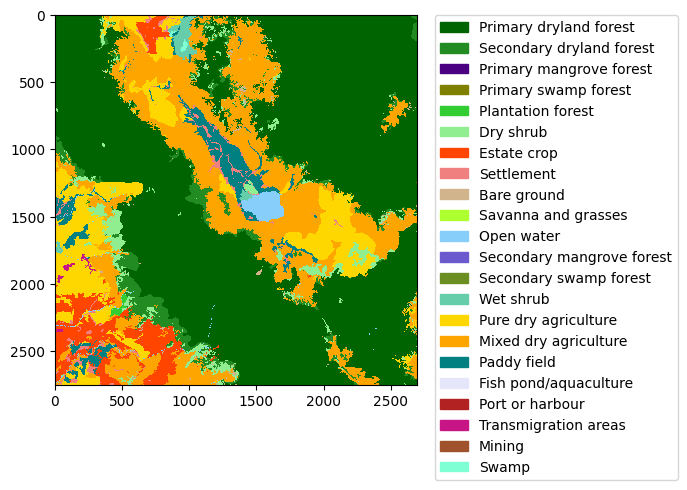

In [5]:
# Remap LC image data
for x in range(0, len(lc_df)):
	lc_dict = lc_df.loc[x]
	lc_image[lc_image == lc_dict['values']] = lc_dict['values_normalize']

# Show the land cover
plt.imshow(lc_image, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
plt.legend(**legend)

In [28]:
# Load satellite imagery
landsat = rio.open(landsat_dir)
landsat_image = landsat.read() / 1e4

In [29]:
result = rio.transform.array_bounds(10, 10, transform)
result

(101.07178823602608,
 -1.767075995391511,
 101.07448318187843,
 -1.7643810495391523)

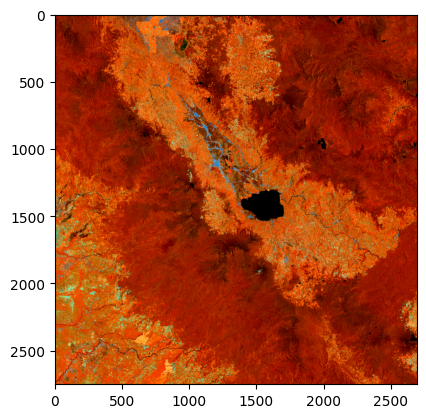

In [30]:
# Create a composite
composite = np.dstack([
	rescale_intensity(landsat_image[4], in_range=(0.125, 0.4), out_range=(0, 1)),
	rescale_intensity(landsat_image[5], in_range=(0.1, 0.3), out_range=(0, 1)),
	rescale_intensity(landsat_image[6], in_range=(0.075, 0.2), out_range=(0, 1))
])

# Visualize composite
plt.imshow(composite)

In [31]:
# Calculate unique values in the land cover
uniques = np.unique(lc_image)
uniques

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 20, 21, 22],
      dtype=int32)

In [ ]:
# Width/height of the new image
image_width = 64

# Define image per land cover
image_per_lc = 20

plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Coords list
coords_list = []

# Get the land cover clip using the the width
for x in range(0, len(uniques)):
	lc = uniques[x]

	coords = np.argwhere(lc_image == lc)
	coords_filter = []

	# Coordinate
	for c in coords:
		cond1 = (c[0] - (image_width / 2)) >= 0
		cond2 = (c[1] - (image_width / 2)) >= 0
		cond3 = (c[0] + (image_width / 2)) <= lc_image.shape[0]
		cond4 = (c[1] + (image_width / 2)) <= lc_image.shape[1]

		if (cond1 & cond2 & cond3 & cond4):
			coords_filter.append(c)

	if (len(coords_filter) > 0):
		seq = np.arange(len(coords_filter) - 1)
		sample = np.random.choice(seq, size=image_per_lc)
		sample_coord = list(map(lambda x: coords_filter[x], sample))

		for y in range(0, len(sample_coord)):
			# Coordinate
			coord = sample_coord[y]

			# Min max of the coordinate
			max_y = int(coord[0] + (image_width / 2))
			min_y = int(coord[0] - (image_width / 2))
			max_x = int(coord[1] + (image_width / 2))
			min_x = int(coord[1] - (image_width / 2))

			coords_list.append([
				min_y,
				max_y,
				min_x,
				max_x
			])

<Figure size 8000x6000 with 0 Axes>

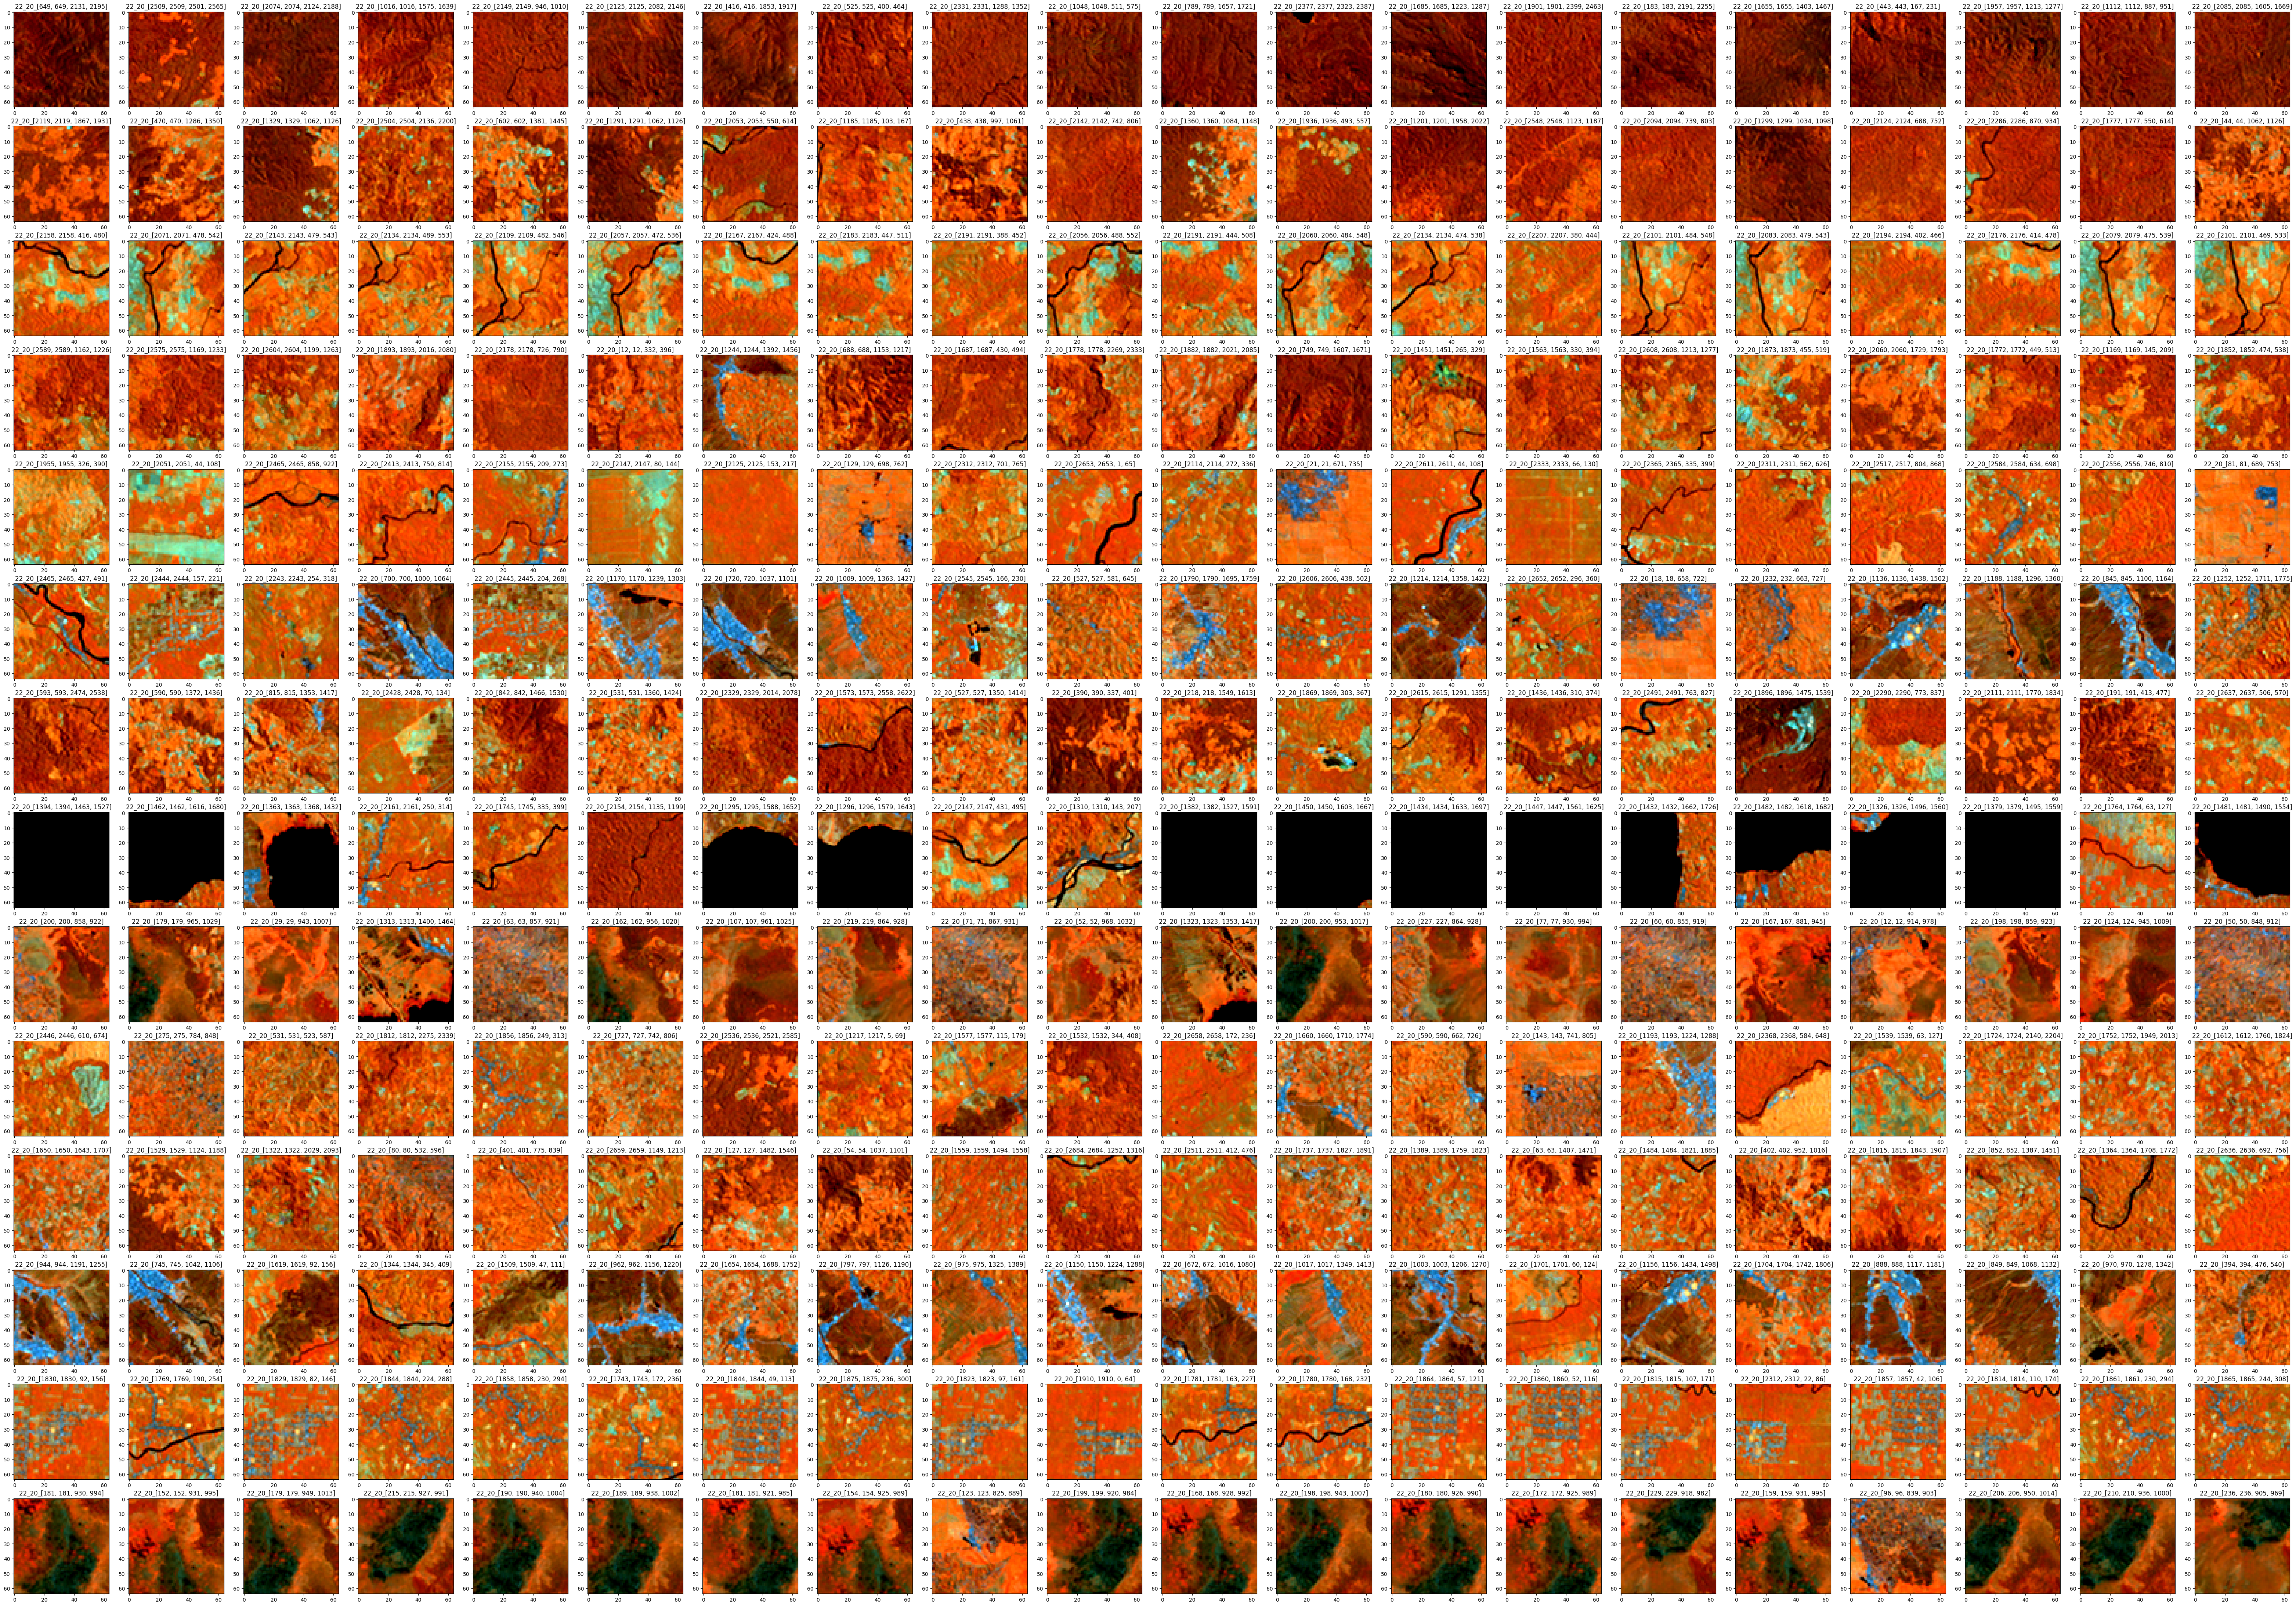

In [40]:
plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Show the clipped image based on coordinate list
for x in range(0, len(coords_list)):
	min_y, max_y, min_x, max_x = coords_list[x]

	image_coord = composite[min_y:max_y, min_x:max_x]
	image_coord_t = np.transpose(image_coord, (2, 0, 1))

	id = f'{lc}_{y + 1}'

	window = rio.windows.Window.from_slices((min_y, max_y), (min_x, max_x))
	transform = landsat.window_transform(window)

	# Save image as tiff
	output = rio.open(
		f'data/images/{id}.tif',
		'w',
		'GTiff',
		count=image_coord_t.shape[0],
		width=image_coord_t.shape[2],
		height=image_coord_t.shape[1],
		dtype='float32',
		compress='lzw',
		resampling=Resampling.nearest,
		transform=transform,
		crs=landsat.crs
	)
	output.write(image_coord_t)
	output.close()

	# Plot the preview image
	plt.subplot(len(uniques), image_per_lc, x + 1)
	plt.imshow(image_coord)
	plt.title(f'{lc}_{y + 1}_[{min_y}, {min_y}, {min_x}, {max_x}]')

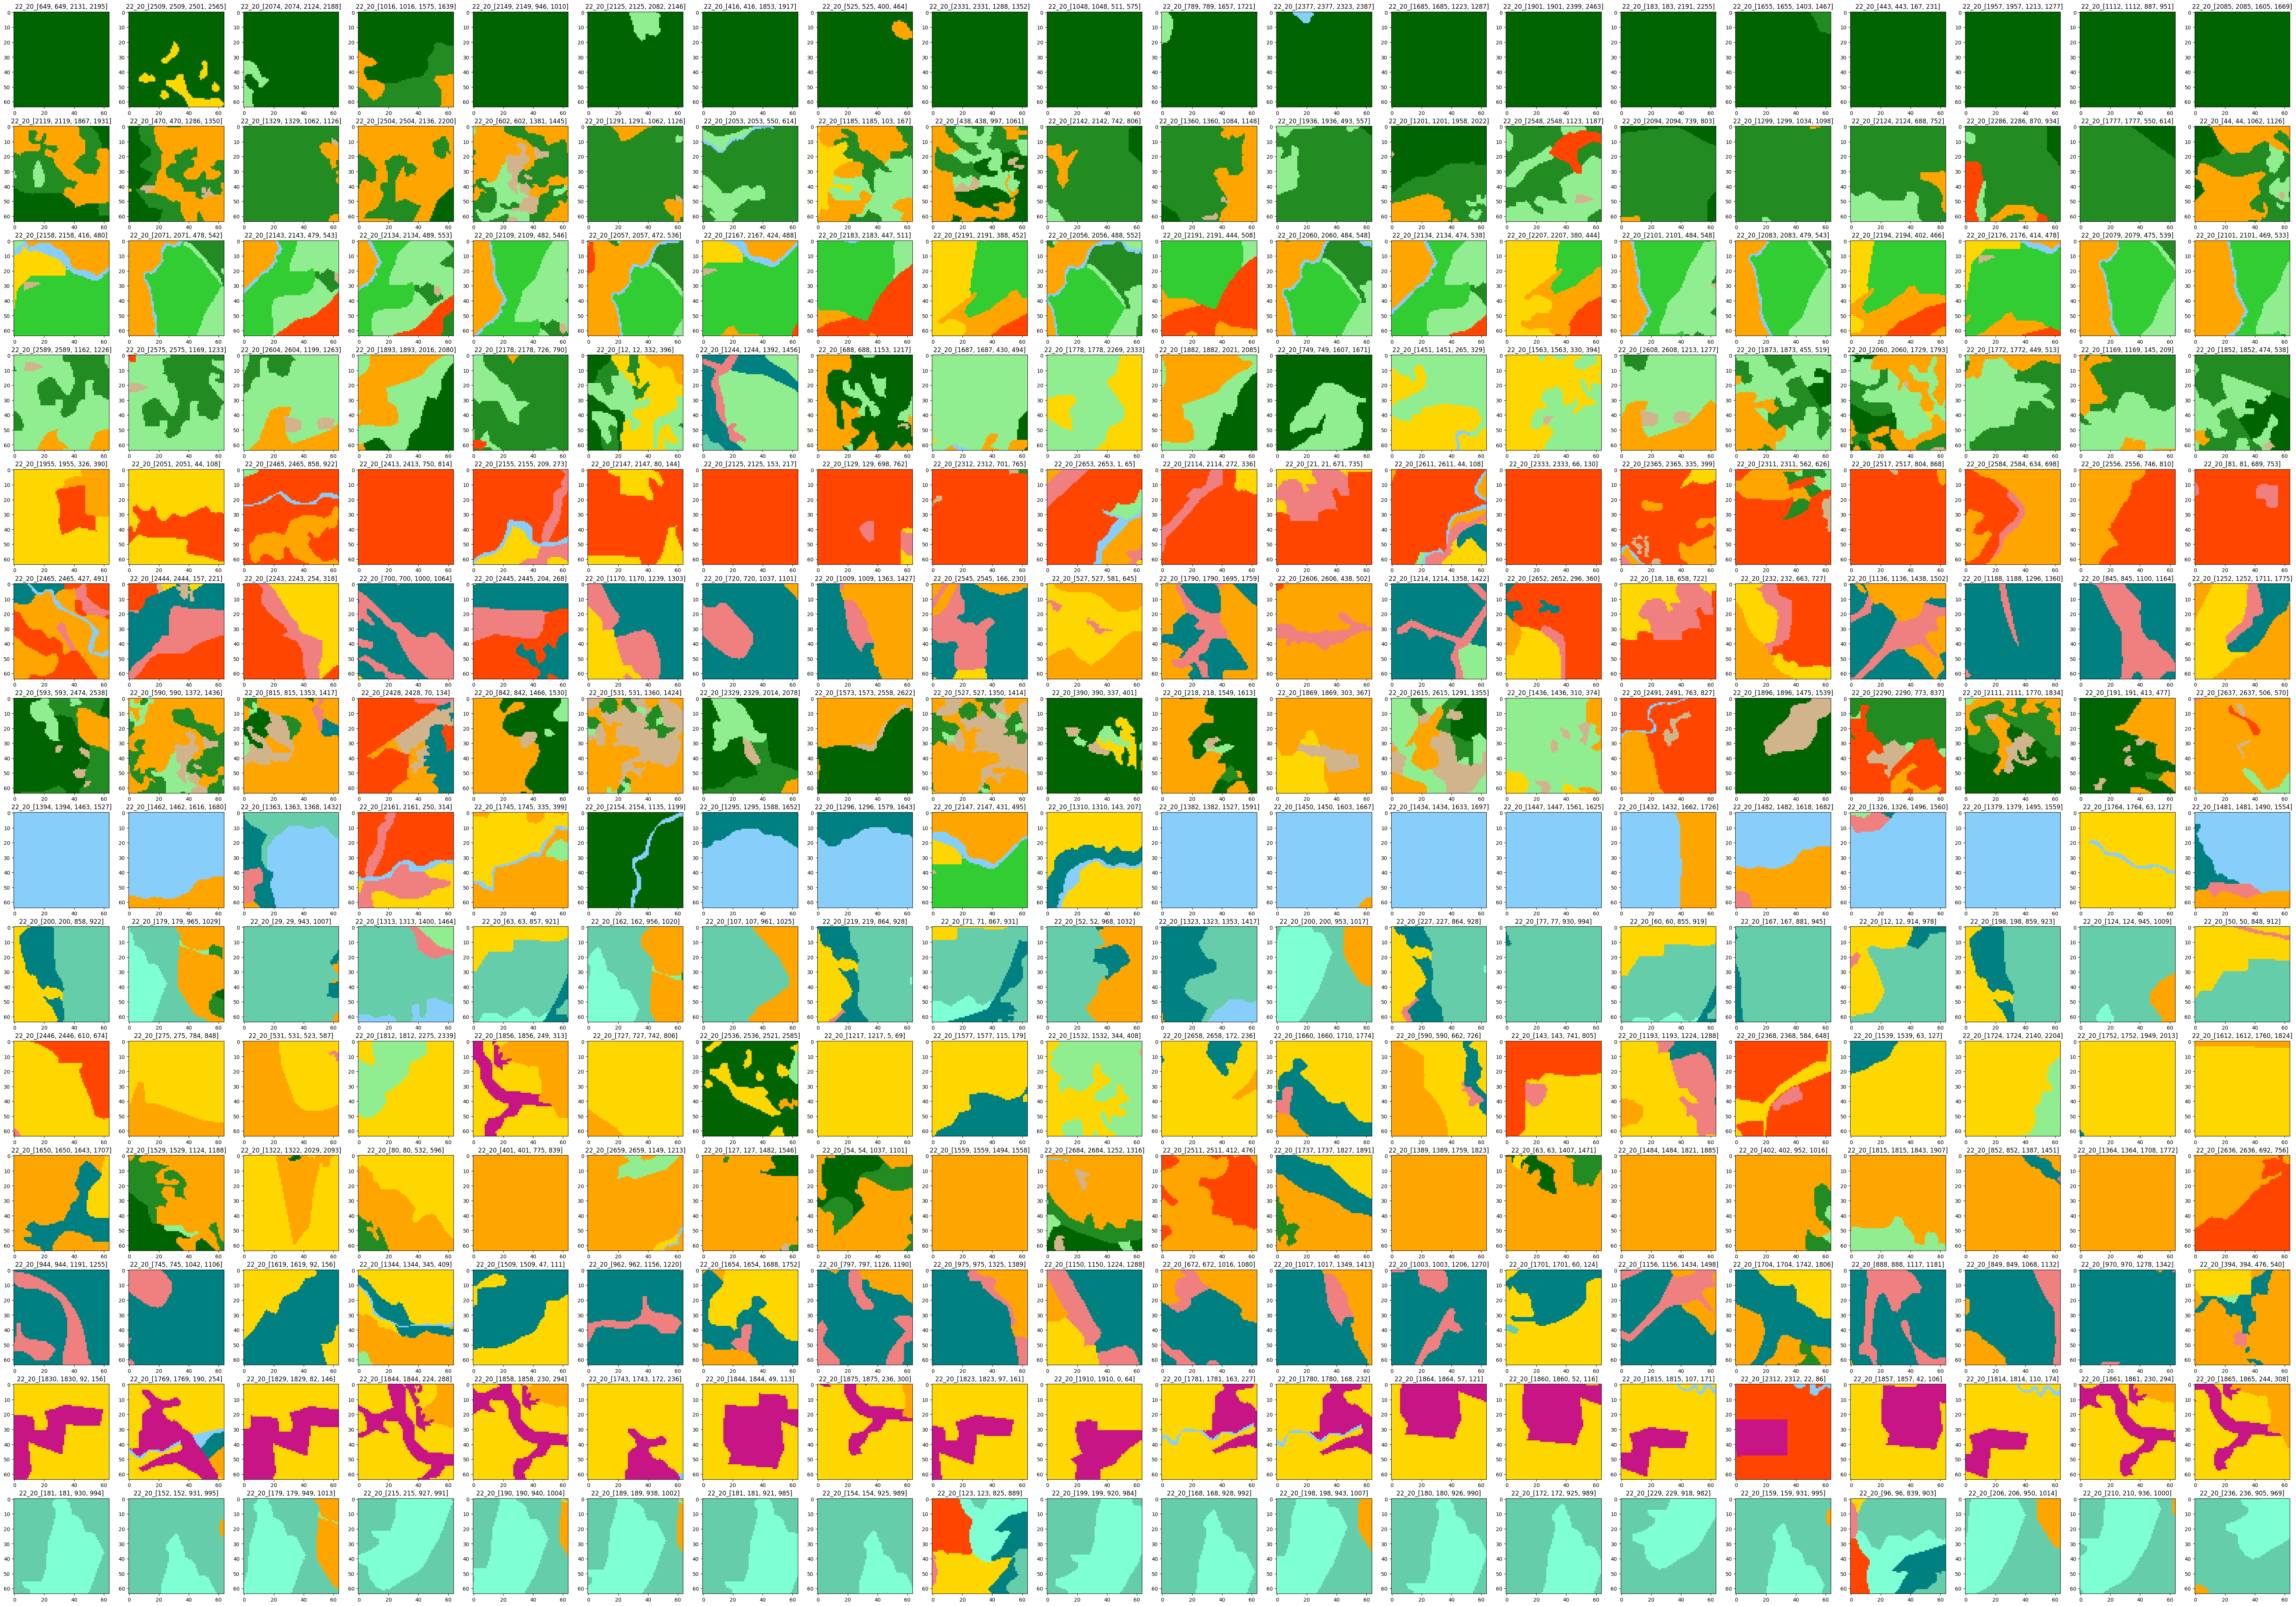

In [41]:
plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Show the clipped image based on coordinate list
for x in range(0, len(coords_list)):
	min_y, max_y, min_x, max_x = coords_list[x]

	# Get the image using the coordinate with
	lc_coord = lc_image[min_y:max_y, min_x:max_x]

	id = f'{lc}_{y + 1}'

	window = rio.windows.Window.from_slices((min_y, max_y), (min_x, max_x))
	transform = landsat.window_transform(window)

	# Save lc
	output = rio.open(
		f'data/lcs/{id}.tif',
		'w',
		'GTiff',
		count=1,
		width=lc_coord.shape[1],
		height=lc_coord.shape[0],
		dtype='uint8',
		compress='lzw',
		resampling=Resampling.nearest,
		transform=transform,
		crs=landsat.crs
	)
	output.write(lc_coord, 1)
	output.write_colormap(1, dict_palette)
	output.close()

	plt.subplot(len(uniques), image_per_lc, x + 1)
	plt.imshow(lc_coord, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
	plt.title(f'{lc}_{y + 1}_[{min_y}, {min_y}, {min_x}, {max_x}]')